In [1]:
import pandas as pd
from google.cloud import bigquery
from catboost import *
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from collections import Counter

In [2]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

def model_eval(y_true, y_pred):
    class_report = classification_report(y_pred=y_pred, y_true=y_true)
    print class_report
    accuracy = accuracy_score(y_pred=y_pred, y_true=y_true)
    print 'Accuracy:', accuracy
    f1 = f1_score(y_true, y_pred, average='weighted')
    print 'F1 Score:', f1
    print '-' * 60

In [3]:
#Reading training data
train_raw = pd.read_json('data/train.json')

In [4]:
#Data extraction and processing for training
X_feature_list = ['_source_coachable', '_source_country_code', '_source_discoverable', '_source_sponsored_campaign', '_source_sponsorship_active', '_source_user_state', 'petition_discoverable', 'petition_organization_city', 'petition_organization_country_code', 'petition_organization_formatted_location_string', 'petition_organization_name', 'petition_organization_non_profit', 'petition_organization_state', 'petition_petition_status', 'petition_primary_target_additional_data_title', 'petition_primary_target_is_person', 'petition_primary_target_publicly_visible', 'petition_primary_target_type', 'petition_relevant_location_city', 'petition_relevant_location_country_code', 'petition_sponsored_campaign', 'petition_user_city', 'petition_user_country_code', 'petition_user_state_code', '_score', 'petition_calculated_goal', 'petition_displayed_signature_count', 'petition_progress', 'petition_total_signature_count', 'petition_weekly_signature_count']
y_target = 'petition_is_victory'

cat_variables = ['_source_coachable', '_source_country_code', '_source_discoverable', '_source_sponsored_campaign', '_source_sponsorship_active', '_source_user_state', 'petition_discoverable', 'petition_organization_city', 'petition_organization_country_code', 'petition_organization_formatted_location_string', 'petition_organization_name', 'petition_organization_non_profit', 'petition_organization_state', 'petition_petition_status', 'petition_primary_target_additional_data_title', 'petition_primary_target_is_person', 'petition_primary_target_publicly_visible', 'petition_primary_target_type', 'petition_relevant_location_city', 'petition_relevant_location_country_code', 'petition_sponsored_campaign', 'petition_user_city', 'petition_user_country_code', 'petition_user_state_code']
drop_variables = ['petition_petition_status']

for var in drop_variables:
    try:
        cat_variables.remove(var)
    except:
        pass

X = train_raw[X_feature_list]
X.drop(drop_variables, axis=1, inplace=True)
y = train_raw[y_target]

for each in cat_variables:
    X[each].str.encode('ascii', 'replace')
    if X[each].isna().any():
        X[each].fillna('Unknown')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.30, random_state=123, stratify=y_train)

X_train.shape

/home/koushik_kulkarni/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(7434, 29)

In [5]:
#Data description
ratio = sum(y_train=='False')/float(sum(y_train=='True'))
print 'ratio: ', ratio

print pd.DataFrame([
    ('feature_data', X.shape),
    ('label_data', y.shape),
    ('X_train', X_train.shape),
    ('y_train', y_train.shape),
    ('X_eval', X_eval.shape),
    ('y_eval', y_eval.shape),
    ('X_test', X_test.shape),
    ('y_test', y_test.shape),
    ('y_train class_dist', Counter(y_train)),
    ('y_eval class_dist', Counter(y_eval)),
    ('y_test class_dist', Counter(y_test)),
])

ratio:  8.92523364486
                     0                               1
0         feature_data                     (13276, 29)
1           label_data                        (13276,)
2              X_train                      (7434, 29)
3              y_train                         (7434,)
4               X_eval                      (3186, 29)
5               y_eval                         (3186,)
6               X_test                      (2656, 29)
7               y_test                         (2656,)
8   y_train class_dist  {u'True': 749, u'False': 6685}
9    y_eval class_dist  {u'True': 321, u'False': 2865}
10   y_test class_dist  {u'True': 268, u'False': 2388}


In [6]:
# Preparing Categorical Variables position list
import numpy as np
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
categorical_features_pos = column_index(X,cat_variables)

categorical_features_pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

# Parameter Tuning

learning_rate = [float(x) for x in np.linspace(start = 0, stop = 1.0, num = 11)]
min_child_weight = [int(x) for x in np.linspace(start = 0, stop = 3, num = 4)]
max_depth = [int(x) for x in np.linspace(start = 5, stop = 10, num = 6)]
gamma = [int(x) for x in np.linspace(start = 0, stop = 3, num = 4)]
subsample = [float(x) for x in np.linspace(start = 0.5, stop = 1.0, num = 6)]
colsample_bytree = [float(x) for x in np.linspace(start = 0.5, stop = 1.0, num = 6)]
colsample_bylevel = [float(x) for x in np.linspace(start = 0.5, stop = 1.0, num = 6)]
reg_lambda = [float(x) for x in np.linspace(start = 0.5, stop = 1.0, num = 6)]

random_grid = {'learning_rate': learning_rate,
               'depth': max_depth,
               'l2_leaf_reg':np.logspace(-20, -19, 3)
              }

print random_grid


from sklearn.model_selection import RandomizedSearchCV

rf = CatBoostClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, (y_train == 'True').astype(int), cat_features=categorical_features_pos)

print rf_random.best_params_
print rf_random.best_score_

In [7]:
#Generating params dict
# params = rf_random.best_params_
params = {'depth': 9, 'l2_leaf_reg': 1e-19, 'learning_rate': 0.2,} #final params
params['loss_function'] = 'MultiClass'
params['iterations'] = 300
params['random_seed'] = 123
params

{'depth': 9,
 'iterations': 300,
 'l2_leaf_reg': 1e-19,
 'learning_rate': 0.2,
 'loss_function': 'MultiClass',
 'random_seed': 123}

In [8]:
#Catboost Classifier object - training for Victory Prediction
from catboost import CatBoostClassifier

model = CatBoostClassifier(**params)
model.fit(X_train, y_train,
         eval_set=(X_eval,y_eval),
         cat_features=categorical_features_pos,
         use_best_model=True,
         verbose=True,
         plot=1
         )

A Jupyter Widget

0:	learn: -0.5770317	test: -0.5770887	best: -0.5770887 (0)	total: 117ms	remaining: 35.1s
1:	learn: -0.4992243	test: -0.4993546	best: -0.4993546 (1)	total: 405ms	remaining: 1m
2:	learn: -0.4469975	test: -0.4471577	best: -0.4471577 (2)	total: 481ms	remaining: 47.6s
3:	learn: -0.4101134	test: -0.4101843	best: -0.4101843 (3)	total: 564ms	remaining: 41.7s
4:	learn: -0.3753143	test: -0.3754781	best: -0.3754781 (4)	total: 679ms	remaining: 40.1s
5:	learn: -0.3567080	test: -0.3567998	best: -0.3567998 (5)	total: 752ms	remaining: 36.9s
6:	learn: -0.3406098	test: -0.3404633	best: -0.3404633 (6)	total: 800ms	remaining: 33.5s
7:	learn: -0.3231400	test: -0.3240577	best: -0.3240577 (7)	total: 889ms	remaining: 32.5s
8:	learn: -0.3072649	test: -0.3097900	best: -0.3097900 (8)	total: 1.2s	remaining: 38.9s
9:	learn: -0.2962105	test: -0.3008795	best: -0.3008795 (9)	total: 1.35s	remaining: 39.3s
10:	learn: -0.2895613	test: -0.2946544	best: -0.2946544 (10)	total: 1.44s	remaining: 37.7s
11:	learn: -0.2855821	t

92:	learn: -0.1784261	test: -0.2508794	best: -0.2492391 (66)	total: 10.5s	remaining: 23.3s
93:	learn: -0.1777749	test: -0.2507726	best: -0.2492391 (66)	total: 10.6s	remaining: 23.3s
94:	learn: -0.1773301	test: -0.2513342	best: -0.2492391 (66)	total: 10.7s	remaining: 23.2s
95:	learn: -0.1755587	test: -0.2519827	best: -0.2492391 (66)	total: 10.9s	remaining: 23.1s
96:	learn: -0.1751342	test: -0.2517315	best: -0.2492391 (66)	total: 11s	remaining: 23s
97:	learn: -0.1746177	test: -0.2519631	best: -0.2492391 (66)	total: 11.1s	remaining: 23s
98:	learn: -0.1729951	test: -0.2520158	best: -0.2492391 (66)	total: 11.3s	remaining: 22.9s
99:	learn: -0.1724143	test: -0.2520154	best: -0.2492391 (66)	total: 11.4s	remaining: 22.8s
100:	learn: -0.1702425	test: -0.2519887	best: -0.2492391 (66)	total: 11.5s	remaining: 22.7s
101:	learn: -0.1692800	test: -0.2518635	best: -0.2492391 (66)	total: 11.7s	remaining: 22.6s
102:	learn: -0.1690245	test: -0.2519412	best: -0.2492391 (66)	total: 11.8s	remaining: 22.5s
10

182:	learn: -0.1188080	test: -0.2634135	best: -0.2492391 (66)	total: 21.4s	remaining: 13.7s
183:	learn: -0.1186665	test: -0.2634742	best: -0.2492391 (66)	total: 21.5s	remaining: 13.6s
184:	learn: -0.1183353	test: -0.2634898	best: -0.2492391 (66)	total: 21.7s	remaining: 13.5s
185:	learn: -0.1177533	test: -0.2634571	best: -0.2492391 (66)	total: 21.8s	remaining: 13.3s
186:	learn: -0.1174343	test: -0.2636957	best: -0.2492391 (66)	total: 21.9s	remaining: 13.2s
187:	learn: -0.1168050	test: -0.2638342	best: -0.2492391 (66)	total: 22s	remaining: 13.1s
188:	learn: -0.1157520	test: -0.2636929	best: -0.2492391 (66)	total: 22.1s	remaining: 13s
189:	learn: -0.1148337	test: -0.2639375	best: -0.2492391 (66)	total: 22.3s	remaining: 12.9s
190:	learn: -0.1144306	test: -0.2636147	best: -0.2492391 (66)	total: 22.4s	remaining: 12.8s
191:	learn: -0.1139995	test: -0.2635116	best: -0.2492391 (66)	total: 22.5s	remaining: 12.6s
192:	learn: -0.1137732	test: -0.2633380	best: -0.2492391 (66)	total: 22.6s	remaining

272:	learn: -0.0803756	test: -0.2754328	best: -0.2492391 (66)	total: 31.7s	remaining: 3.14s
273:	learn: -0.0799954	test: -0.2763744	best: -0.2492391 (66)	total: 31.8s	remaining: 3.02s
274:	learn: -0.0798589	test: -0.2763268	best: -0.2492391 (66)	total: 32s	remaining: 2.9s
275:	learn: -0.0796810	test: -0.2768854	best: -0.2492391 (66)	total: 32.1s	remaining: 2.79s
276:	learn: -0.0783742	test: -0.2771976	best: -0.2492391 (66)	total: 32.2s	remaining: 2.67s
277:	learn: -0.0783522	test: -0.2771919	best: -0.2492391 (66)	total: 32.3s	remaining: 2.56s
278:	learn: -0.0780921	test: -0.2775436	best: -0.2492391 (66)	total: 32.4s	remaining: 2.44s
279:	learn: -0.0780527	test: -0.2776446	best: -0.2492391 (66)	total: 32.5s	remaining: 2.32s
280:	learn: -0.0778041	test: -0.2779707	best: -0.2492391 (66)	total: 32.6s	remaining: 2.21s
281:	learn: -0.0776948	test: -0.2781242	best: -0.2492391 (66)	total: 32.7s	remaining: 2.09s
282:	learn: -0.0775849	test: -0.2783793	best: -0.2492391 (66)	total: 32.8s	remainin

In [9]:
#Victory: Model eval scores train dataset
y_pred_train = model.predict(X_train)
print 'Model eval scores train dataset'
model_eval(y_train, y_pred_train)

Model eval scores train dataset
              precision    recall  f1-score   support

       False       0.92      1.00      0.96      6685
        True       0.88      0.27      0.41       749

   micro avg       0.92      0.92      0.92      7434
   macro avg       0.90      0.63      0.68      7434
weighted avg       0.92      0.92      0.90      7434

Accuracy: 0.9223836427226257
F1 Score: 0.9031441467206164
------------------------------------------------------------


In [10]:
#Victory: Model eval scores eval dataset
y_pred_eval = model.predict(X_eval)
print 'Model eval scores eval dataset'
model_eval(y_eval, y_pred_eval)

Model eval scores eval dataset
              precision    recall  f1-score   support

       False       0.92      0.99      0.95      2865
        True       0.68      0.20      0.30       321

   micro avg       0.91      0.91      0.91      3186
   macro avg       0.80      0.59      0.63      3186
weighted avg       0.89      0.91      0.89      3186

Accuracy: 0.9096045197740112
F1 Score: 0.8864426322008913
------------------------------------------------------------


In [11]:
#Victory: Model eval scores test dataset
y_pred_test = model.predict(X_test)
print 'Model eval scores test dataset'
model_eval(y_test, y_pred_test)

Model eval scores test dataset
              precision    recall  f1-score   support

       False       0.91      0.99      0.95      2388
        True       0.65      0.15      0.24       268

   micro avg       0.91      0.91      0.91      2656
   macro avg       0.78      0.57      0.59      2656
weighted avg       0.89      0.91      0.88      2656

Accuracy: 0.9058734939759037
F1 Score: 0.8779926207590414
------------------------------------------------------------


/home/koushik_kulkarni/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


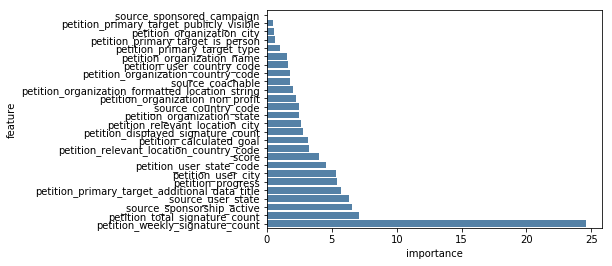

In [12]:
#Generating feature importances generated by trained model
plt.figure()
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importances.sort_values(by='importance', ascending=True, inplace=True)
sns.barplot(x="importance", y="feature", data=feature_importances[(feature_importances.importance >= 0.01)],
               label="Feature Importance", color="steelblue")
plt.show()

The model has complex ctrs, so the SHAP values will be calculated approximately.


Shap for Class = 0


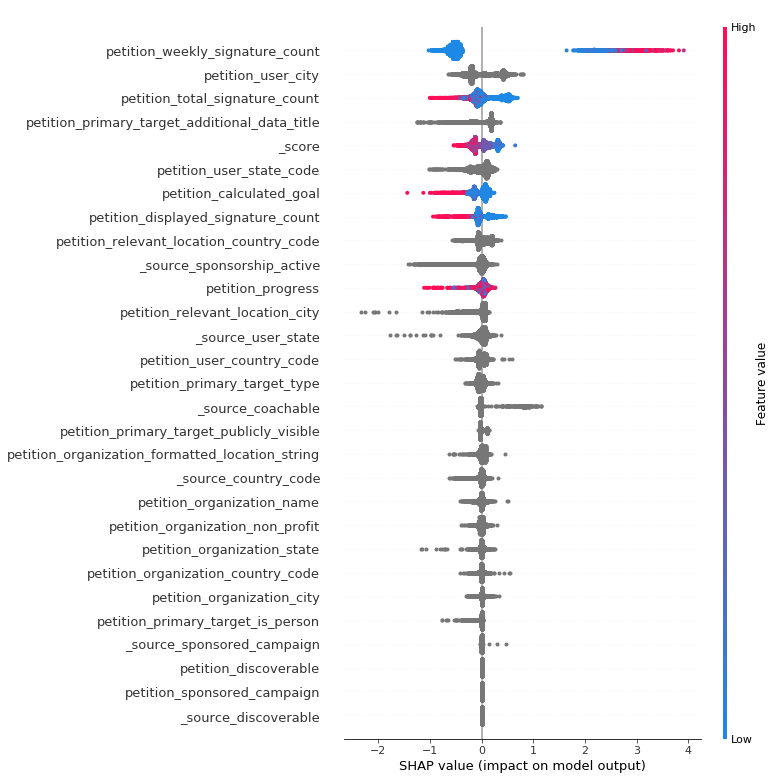

Shap for Class = 1


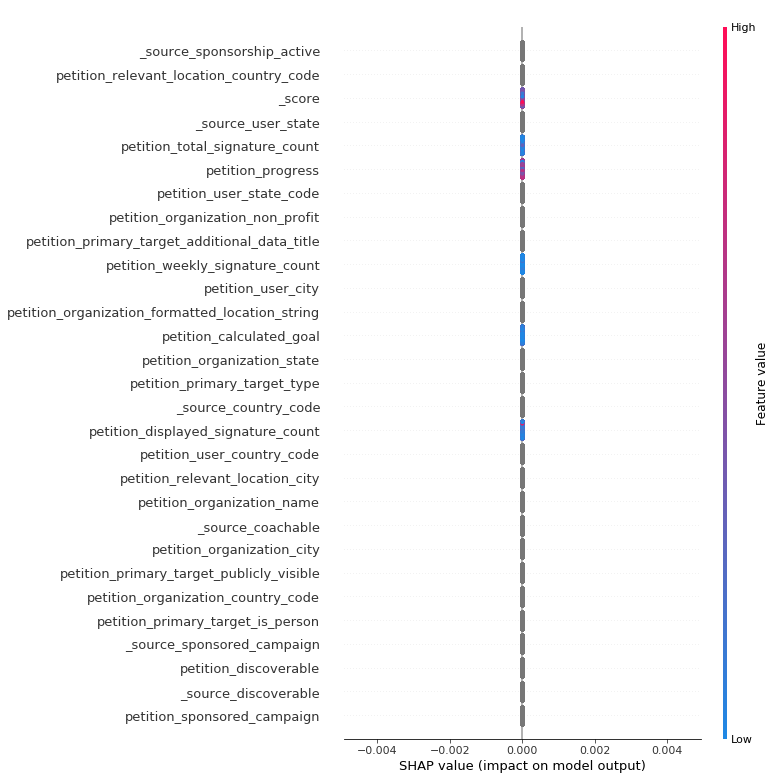

In [14]:
#Generating SHAP diagrams for Class 0 and 1
import shap
import matplotlib.pyplot as plt
plt.ioff() 
plt.tight_layout()
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=categorical_features_pos))
print "Shap for Class = 0"
fig_0 = shap.summary_plot(shap_values[0], X_train, plot_type='dot', show=True, max_display = 120)
plt.show(fig_0)
print "Shap for Class = 1"
fig_1 = shap.summary_plot(shap_values[1], X_train, plot_type='dot', show=True, max_display = 120)
plt.show(fig_1)

# Victory Prediction

In [15]:
#Reading validation data
validation_raw = pd.read_json('data/validation.json')

In [16]:
#Generating victory prediction feature set
X_feature_list = ['_source_coachable', '_source_country_code', '_source_discoverable', '_source_sponsored_campaign', '_source_sponsorship_active', '_source_user_state', 'petition_discoverable', 'petition_organization_city', 'petition_organization_country_code', 'petition_organization_formatted_location_string', 'petition_organization_name', 'petition_organization_non_profit', 'petition_organization_state', 'petition_petition_status', 'petition_primary_target_additional_data_title', 'petition_primary_target_is_person', 'petition_primary_target_publicly_visible', 'petition_primary_target_type', 'petition_relevant_location_city', 'petition_relevant_location_country_code', 'petition_sponsored_campaign', 'petition_user_city', 'petition_user_country_code', 'petition_user_state_code', '_score', 'petition_calculated_goal', 'petition_displayed_signature_count', 'petition_progress', 'petition_total_signature_count', 'petition_weekly_signature_count']

cat_variables = ['_source_coachable', '_source_country_code', '_source_discoverable', '_source_sponsored_campaign', '_source_sponsorship_active', '_source_user_state', 'petition_discoverable', 'petition_organization_city', 'petition_organization_country_code', 'petition_organization_formatted_location_string', 'petition_organization_name', 'petition_organization_non_profit', 'petition_organization_state', 'petition_petition_status', 'petition_primary_target_additional_data_title', 'petition_primary_target_is_person', 'petition_primary_target_publicly_visible', 'petition_primary_target_type', 'petition_relevant_location_city', 'petition_relevant_location_country_code', 'petition_sponsored_campaign', 'petition_user_city', 'petition_user_country_code', 'petition_user_state_code']
drop_variables = ['petition_petition_status']

for var in drop_variables:
    try:
        cat_variables.remove(var)
    except:
        pass

X_pred = validation_raw[X_feature_list]
X_pred.drop(drop_variables, axis=1, inplace=True)

for each in cat_variables:
    X_pred[each].str.encode('ascii', 'replace')
    if X_pred[each].isna().any():
        X_pred[each].fillna('Unknown')

#Generating victory prediction labels
y_pred = model.predict(X_pred)

#Concating victory predictions with original validation prediction ID column
final_pred = pd.concat([validation_raw.petition_id, pd.DataFrame(y_pred, columns=['predicted_petition_is_victory'])], axis=1)
final_pred

,petition_id,predicted_petition_is_victory
0,12671749,True
1,9666287,False
2,12925824,False
3,10569656,False
4,12985272,False
5,11921560,True
6,11950168,True
7,12044524,True
8,7819910,False
9,249516,True


# Category prediction

In [17]:
#Data extraction and processing for training
category_train_data = pd.DataFrame()
for index,row in train_raw.iterrows():
    highlight = pd.DataFrame([train_raw.loc[index,'highlight_description'] + train_raw.loc[index,'highlight_ask']]
                             ,columns=['highlight_description'])
    extracted_tags = highlight['highlight_description'].str.extractall('<mark>(.*?)</mark>')
    category_train_data.loc[index,'petition_category'] = train_raw.loc[index, 'petition_category']
    for i,tag in enumerate(sorted(set(extracted_tags[0L][0].str.lower()))):
        category_train_data.loc[index,'tag_' + tag] = 1

In [18]:
#Category prediction training feature and label sets
X_cat = category_train_data.drop(['petition_category'], axis=1)
y_cat = category_train_data['petition_category']
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat
                                                                    , test_size=0.20
                                                                    , random_state=123
                                                                    , stratify=y_cat)
X_cat_train, X_cat_eval, y_cat_train, y_cat_eval = train_test_split(X_cat_train
                                                                    , y_cat_train
                                                                    , test_size=0.30
                                                                    , random_state=123
                                                                    , stratify=y_cat_train)

In [19]:
#Catboost Classifier object - training
cat_model = CatBoostClassifier(iterations=10, learning_rate=0.1, depth=10,loss_function='MultiClass')
cat_model.fit(X_cat_train, y_cat_train,
         eval_set=(X_cat_eval,y_cat_eval),
         use_best_model=True,
         verbose=True,
         plot=1
         )

A Jupyter Widget

0:	learn: -1.2400465	test: -1.2395507	best: -1.2395507 (0)	total: 60.5ms	remaining: 544ms
1:	learn: -1.0096902	test: -1.0092714	best: -1.0092714 (1)	total: 235ms	remaining: 941ms
2:	learn: -0.8458070	test: -0.8455146	best: -0.8455146 (2)	total: 410ms	remaining: 957ms
3:	learn: -0.7208237	test: -0.7206105	best: -0.7206105 (3)	total: 556ms	remaining: 834ms
4:	learn: -0.6213935	test: -0.6212248	best: -0.6212248 (4)	total: 701ms	remaining: 701ms
5:	learn: -0.5402623	test: -0.5400948	best: -0.5400948 (5)	total: 790ms	remaining: 527ms
6:	learn: -0.4729291	test: -0.4727657	best: -0.4727657 (6)	total: 941ms	remaining: 403ms
7:	learn: -0.4161352	test: -0.4159723	best: -0.4159723 (7)	total: 1.1s	remaining: 274ms
8:	learn: -0.3675873	test: -0.3674735	best: -0.3674735 (8)	total: 1.25s	remaining: 139ms
9:	learn: -0.3257945	test: -0.3257037	best: -0.3257037 (9)	total: 1.41s	remaining: 0us

bestTest = -0.3257036552
bestIteration = 9



In [21]:
#Category: Model eval scores train dataset
y_cat_pred_train = cat_model.predict(X_cat_train)
print 'Model eval scores train dataset'
model_eval(y_cat_train, y_cat_pred_train)

Model eval scores train dataset
                   precision    recall  f1-score   support

        education       1.00      1.00      1.00      2324
environment issue       1.00      1.00      1.00       418
      health care       1.00      1.00      1.00      1470
   infrastructure       1.00      1.00      1.00       716
              tax       1.00      1.00      1.00      2506

        micro avg       1.00      1.00      1.00      7434
        macro avg       1.00      1.00      1.00      7434
     weighted avg       1.00      1.00      1.00      7434

Accuracy: 1.0
F1 Score: 1.0
------------------------------------------------------------


In [22]:
#Category: Model eval scores eval dataset
y_cat_pred_eval = cat_model.predict(X_cat_eval)
print 'Model eval scores eval dataset'
model_eval(y_cat_eval, y_cat_pred_eval)

Model eval scores eval dataset
                   precision    recall  f1-score   support

        education       1.00      1.00      1.00       996
environment issue       1.00      1.00      1.00       179
      health care       1.00      1.00      1.00       630
   infrastructure       1.00      1.00      1.00       307
              tax       1.00      1.00      1.00      1074

        micro avg       1.00      1.00      1.00      3186
        macro avg       1.00      1.00      1.00      3186
     weighted avg       1.00      1.00      1.00      3186

Accuracy: 1.0
F1 Score: 1.0
------------------------------------------------------------


In [23]:
#Category: Model eval scores test dataset
y_cat_pred_test = cat_model.predict(X_cat_test)
print 'Model eval scores test dataset'
model_eval(y_cat_test, y_cat_pred_test)

Model eval scores test dataset
                   precision    recall  f1-score   support

        education       1.00      1.00      1.00       831
environment issue       1.00      1.00      1.00       149
      health care       1.00      1.00      1.00       525
   infrastructure       1.00      1.00      1.00       256
              tax       1.00      1.00      1.00       895

        micro avg       1.00      1.00      1.00      2656
        macro avg       1.00      1.00      1.00      2656
     weighted avg       1.00      1.00      1.00      2656

Accuracy: 1.0
F1 Score: 1.0
------------------------------------------------------------


# Category Prediction

In [ ]:
#Generating category prediction feature set
category_validate_data = pd.DataFrame()
for index,row in validation_raw.iterrows():
    highlight = pd.DataFrame([validation_raw.loc[index,'highlight_description'] 
                              + validation_raw.loc[index,'highlight_ask']]
                             ,columns=['highlight_description'])
    extracted_tags = highlight['highlight_description'].str.extractall('<mark>(.*?)</mark>')
    for i,tag in enumerate(sorted(set(extracted_tags[0L][0].str.lower()))):
        category_validate_data.loc[index,'tag_' + tag] = 1

In [ ]:
#Generating category prediction labels
category_validate_pred = cat_model.predict(category_validate_data)

#Concating with previously generated victory prediction labels
final_pred = pd.concat([final_pred, pd.DataFrame(category_validate_pred, columns=['predicted_petition_category'])], axis=1)

#Writing to CSV
final_pred.to_csv('data/actual_submission.csv')
print 'Dataframe written to data/actual_submission.csv'
final_pred